In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
project_path = '/content/drive/MyDrive/ML_Projects/fraud_detection_project'
import os
os.chdir(project_path)
print("Working directory set to:", os.getcwd())


Working directory set to: /content/drive/MyDrive/ML_Projects/fraud_detection_project


# **Fraud Detection with Isolation Forest and XGBoost**

This project explores two complementary approaches to detecting credit-card fraud on a highly imbalanced dataset.
- **Unsupervised approach:** Isolation Forest to flag anomalous transactions without labels.  
- **Supervised approach:** Gradient Boosting (XGBoost) trained on oversampled data.  
The comparison shows how labeled learning can outperform pure anomaly detection when reliable data exists, achieving an ROC-AUC of 0.92.  

All analysis was completed in Python using scikit-learn and visualised with matplotlib and seaborn.

<br/>**Author**: Tarik Abed



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from imblearn.over_sampling import SMOTE



# **1. Data Overview**

Here we'll load and inspect the data.

In [ ]:
df = pd.read_csv('data/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Checking to see if any data type discrepancies.

In [ ]:
df.dtypes

,0
Time,float64
V1,float64
V2,float64
V3,float64
V4,float64
V5,float64
V6,float64
V7,float64
V8,float64
V9,float64


Basic analysis of the columns.

In [ ]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Checking for any null/missing values.

In [ ]:
df.isnull().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


Now we have determined consistency in data types amongst columns, as well no missing values,  we can begin EDA.

# **2. Exploratory Data Analysis**

## 2.1 Class Imbalance Check

In the case of this credit card transation data, the transactions are highly unbalanced (fraud < normal) and as a result we must determine the degree of imbalance so we can understand the evaluation metric we should use.

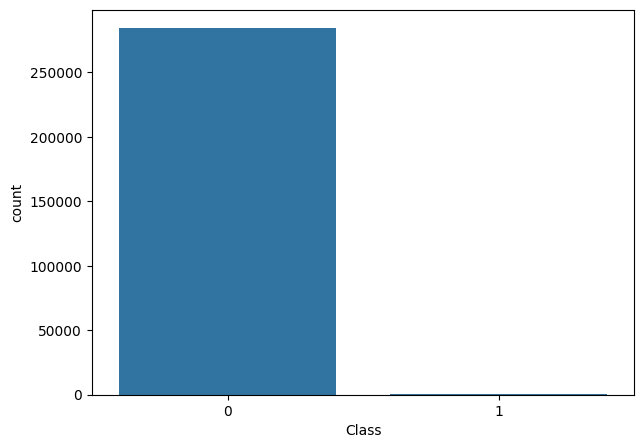

In [ ]:
plt.figure(figsize=(7,5))
fig = sns.countplot(x="Class", data=df)
plt.show()

As was expected the data is highly imbalanced, with non-fraudulent transactions vastly outweighing that of the fraudelent transactions.

<br/> Therefore, the use of an **accuracy based evaluation metric would be misleading**. A model that predicts 'non-fraud' would achieve an accuracy of ~99% and fail to identify a single fraudulent case.

<br/> Therefore, to properly evaluate model performance on imbalanced data, we use metrics that **focus on the minority (positive) class**, namely precision, recall, and their combination, **the F1-score.**

##2.2 Transaction Amount Distribution






To explore whether fraudulent transactions differ in size compared to legitimate ones,
we examine the distribution of the **Amount** variable.

- Fraud often occurs with unusually small or large amounts.
- By comparing these distributions, we can see if **Amount** helps separate the two classes.

If fraudulent transactions cluster in a specific range (e.g., mostly high-value),
this suggests the **Amount** variable has predictive power.
<br/><br/>We will expolore this by plotting two histograms for both fraudulent and non-fraudulent data:

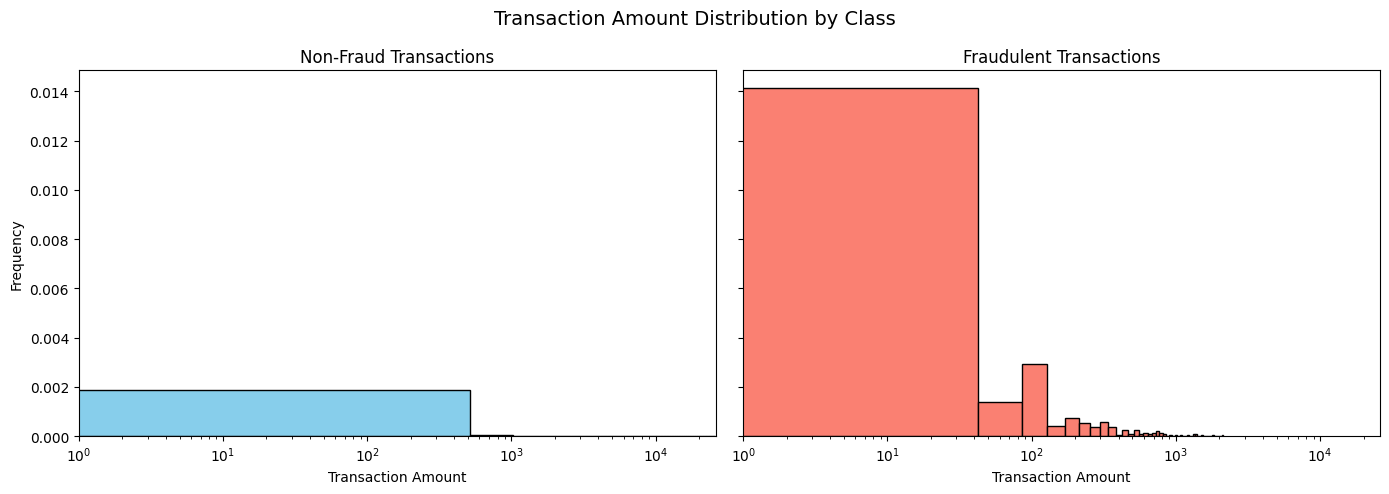

In [ ]:

# Splits into fraud and non-fraud
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# histogram for non-fraud
axes[0].hist(non_fraud['Amount'], bins=50, color='skyblue', edgecolor='black', density=True)
axes[0].set_title('Non-Fraud Transactions')
axes[0].set_xlabel('Transaction Amount')
axes[0].set_ylabel('Frequency')

# Plots histogram for fraud
axes[1].hist(fraud['Amount'], bins=50, color='salmon', edgecolor='black', density=True)
axes[1].set_title('Fraudulent Transactions')
axes[1].set_xlabel('Transaction Amount')
axes[0].set_xscale('log')
axes[1].set_xscale('log')
axes[0].set_xlim(1, 26000)
axes[1].set_xlim(1, 26000)

plt.suptitle('Transaction Amount Distribution by Class', fontsize=14)
plt.tight_layout()
plt.show()

Using a **logarithmic x-axis** allows us to visualise the full range of transaction amounts, spanning several orders of magnitude (from small payments under £10 to amounts over £20,000).

The plots show that both fraudulent and non-fraudulent transactions are heavily **right-skewed**.
However, this scale compresses the dense region near £0,
so to observe finer differences between the two classes we next zoom into the lower value range.


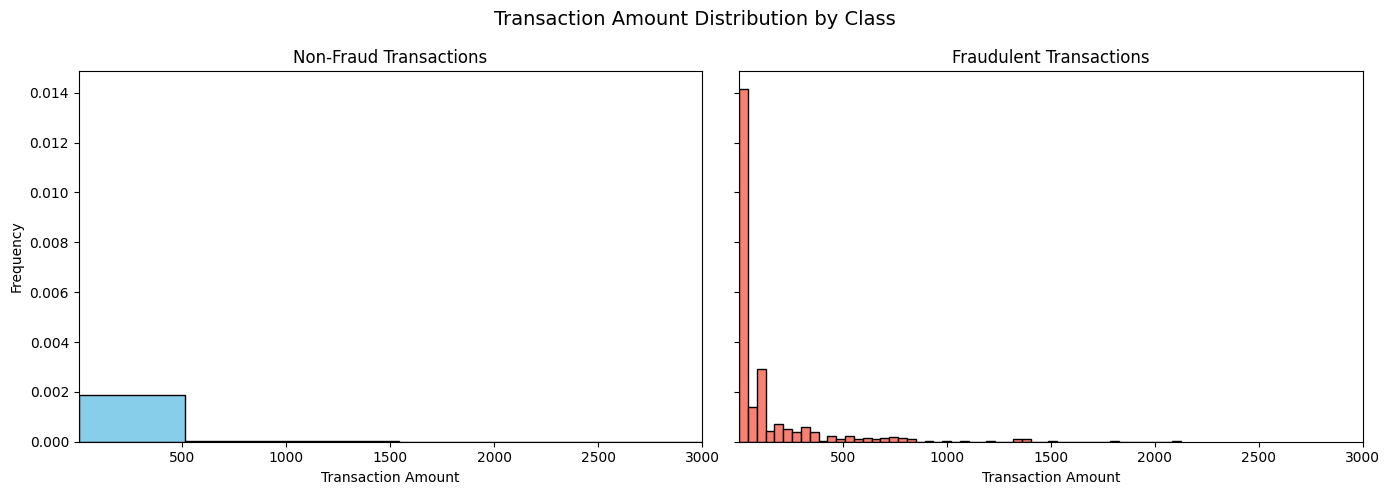

In [ ]:

# Splits into fraud and non-fraud
fraud = df[df['Class'] == 1]
non_fraud = df[df['Class'] == 0]

# Creates two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharex=True, sharey=True)

# Plots histogram for non-fraud
axes[0].hist(non_fraud['Amount'], bins=50, color='skyblue', edgecolor='black', density=True)
axes[0].set_title('Non-Fraud Transactions')
axes[0].set_xlabel('Transaction Amount')
axes[0].set_ylabel('Frequency')

# Plots histogram for fraud
axes[1].hist(fraud['Amount'], bins=50, color='salmon', edgecolor='black', density=True)
axes[1].set_title('Fraudulent Transactions')
axes[1].set_xlabel('Transaction Amount')
# Now linear x-scale
axes[0].set_xscale('linear')
axes[1].set_xscale('linear')
# Reduced x-axis to 5,000
axes[0].set_xlim(1, 3000)
axes[1].set_xlim(1, 3000)

plt.suptitle('Transaction Amount Distribution by Class', fontsize=14)
plt.tight_layout()
plt.show()

While fraudulent transactions show a slightly longer tail (indicating that the instances of fraud sometimes occur at higher amounts), the overall pattern is not distinct enough to strongly differentiate between the two classes on this feature alone.

Nonetheless, this step is a useful part of exploratory analysis and confirms:
- The dataset is heavily skewed toward small transaction amounts.
- Extreme outliers exist and may affect model scaling.
- The **Amount** feature may provide some value when combined with others,
  but is unlikely to be a strong discriminator in its own right.

## 2.3 Outlier and Range Analysis

Before moving onto data preprocessing, it is important we understand the range, shape and spread of each variable. This step helps identify outliers, skewed distributions, or features that are already standardised.

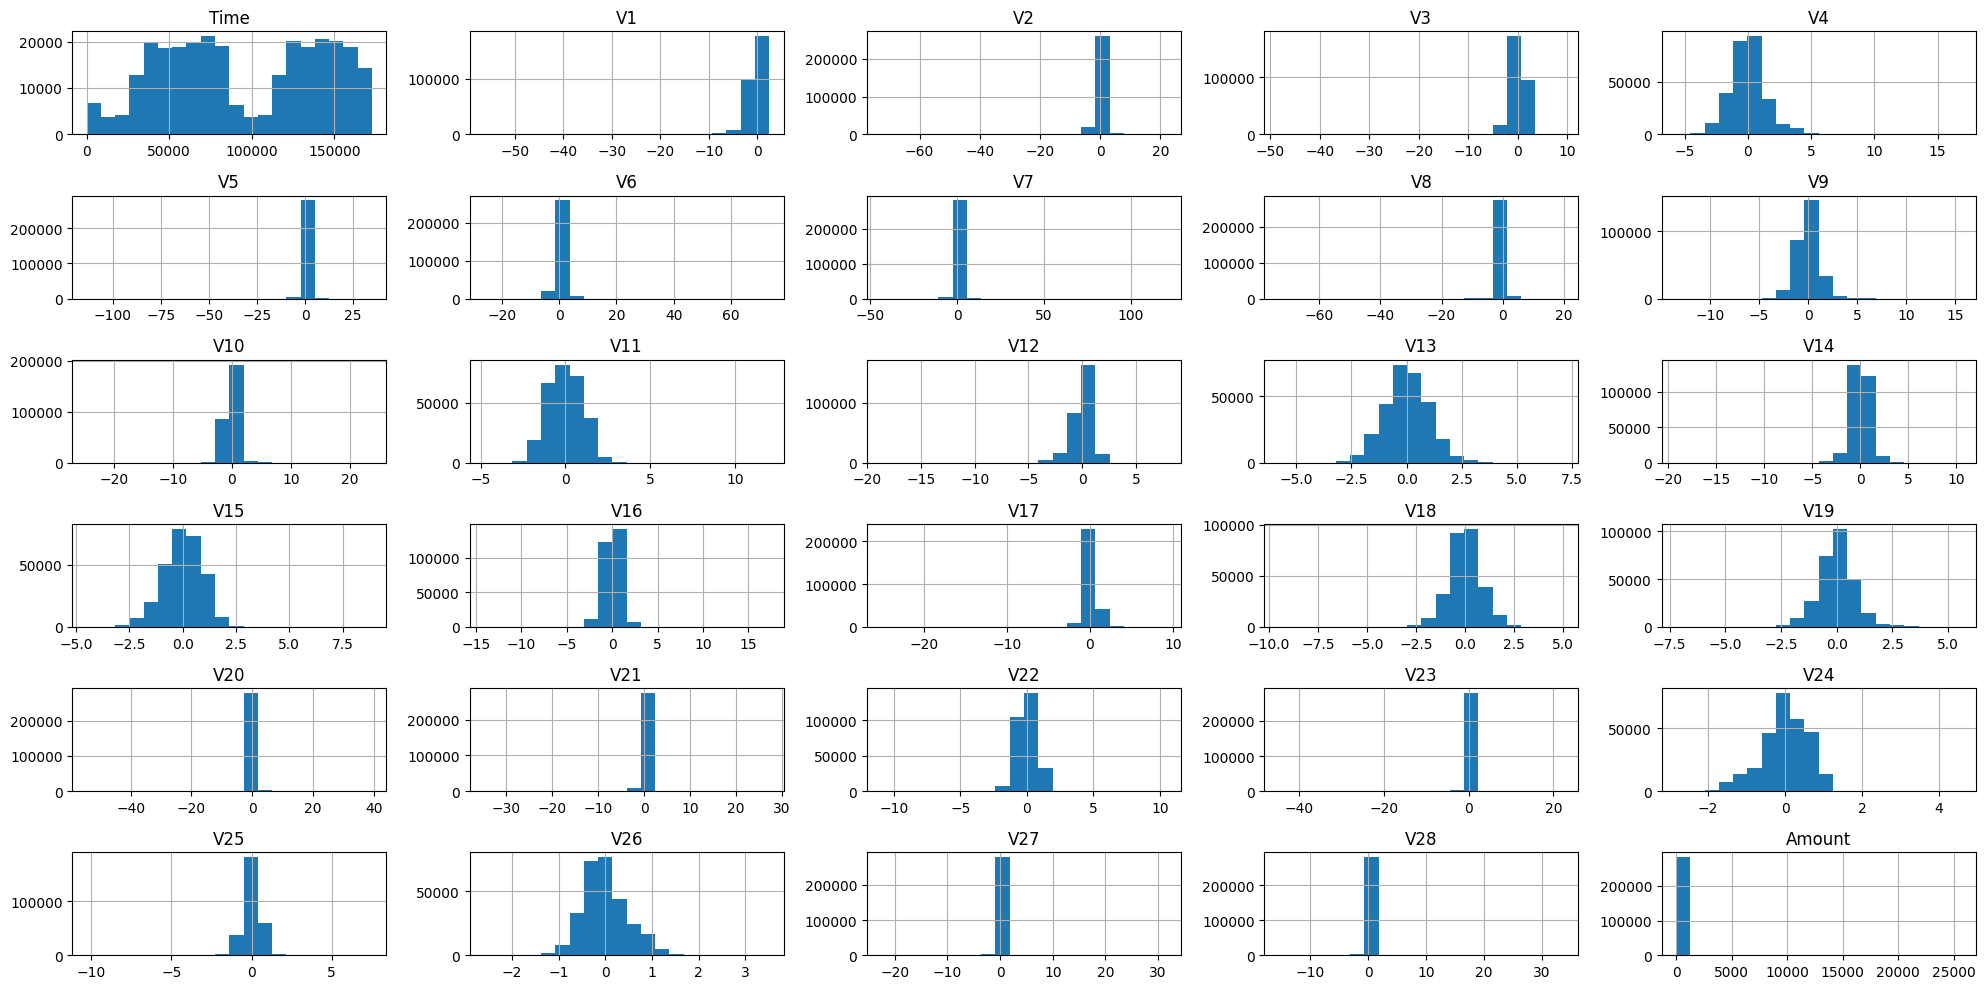

In [ ]:
df_features = df.drop(columns='Class')   # keeping only the input features
df_features.hist(bins=20, figsize=(20,10))
plt.tight_layout()
plt.show()


In [ ]:
df[['Time','Amount']].describe()


,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


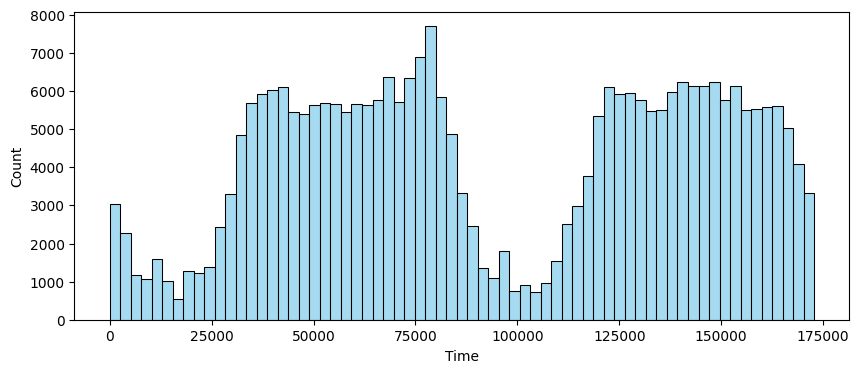

In [ ]:
plt.figure(figsize=(10,4))
fig = sns.histplot(df['Time'], color="skyblue")
plt.show()

The histograms above show the distribution and range of each numerical variable in the dataset. They confirm several important characteristics relevant for the next preprocessing stage:

**PCA Components (V1–V28)**  
   - These are centred roughly around 0 and appear approximately bell-shaped.  
   - Their scales are already similar (roughly between −30 and +30), confirming that they have been standardised through the PCA transformation *(confirming kaggle dataset description).*  
   - *No additional scaling or transformation required.*
<br/>**Amount**  
   - Highly right skewed, with most transactions concentrated below \$500 and a long tail extending up to \$25,000 (as can be determined from table above).  
   - This large numeric range means the Amount variable would dominate distance based models such as **Isolation Forest** if left unscaled.  
   - *Will be transformed before modelling.*
<br/>**Time**
  - Its range is much larger than that of PCA components, but it represents sequence order rather than a monetary or behavioural measure.  
   - *May be scaled or dropped depending on whether temporal effects are used in modelling.*




# **3. Data Preprocessing and Scaling**

**Before training the models, we need to prepare our features:**

- The “Class” column will be separated as our target variable.

- The “Amount” feature will be scaled using RobustScaler to reduce the effect of extreme values.

- The “Time” feature will be dropped since it does not carry predictive value for this dataset.

- This ensures both models (Isolation Forest and Gradient Boosting) work on clean, normalised input data.

In [ ]:


from sklearn.preprocessing import RobustScaler

X = df.drop('Class', axis=1)
y = df['Class']

scaler = RobustScaler()
X['Amount'] = scaler.fit_transform(X[['Amount']])

X = X.drop('Time', axis=1)

print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)


Feature matrix shape: (284807, 29)
Target vector shape: (284807,)


# **4. Train–Test Split and Class Balancing**

**The dataset is extremely imbalanced**, with only around 0.17% of all transactions being fraudulent.

To ensure fair model evaluation, the data is split using **stratified sampling**, preserving the same fraud to non-fraud ratio across training and test sets.

Then, to train the models effectively, we apply random oversampling on the training set. This duplicates minority (fraud) samples until the classes are balanced.
This prevents the model from simply predicting “non-fraud” for every case.

In [ ]:


# Split dataset (70% train, 30% test) using stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Fraud in training set: {y_train.sum()} ({(y_train.mean() * 100):.2f}%)")
print(f"Fraud in test set: {y_test.sum()} ({(y_test.mean() * 100):.2f}%)")


def random_oversample(X, y):
    np.random.seed(42)
    X_majority = X[y == 0]
    X_minority = X[y == 1]


    indices = np.random.choice(X_minority.index, len(X_majority), replace=True)
    X_minority_resampled = X_minority.loc[indices]
    y_minority_resampled = pd.Series([1] * len(X_majority))


    X_balanced = pd.concat([X_majority, X_minority_resampled], axis=0)
    y_balanced = pd.concat([pd.Series([0] * len(X_majority)), y_minority_resampled], axis=0)

    shuffle_idx = np.random.permutation(len(X_balanced))
    X_balanced = X_balanced.iloc[shuffle_idx].reset_index(drop=True)
    y_balanced = y_balanced.iloc[shuffle_idx].reset_index(drop=True)

    return X_balanced, y_balanced

X_train_balanced, y_train_balanced = random_oversample(X_train, y_train)

print("\nBalanced training set:")
print(f" Legitimate: {(y_train_balanced == 0).sum()}, Fraud: {(y_train_balanced == 1).sum()}")
print(f" Fraud percentage: {y_train_balanced.mean() * 100:.2f}%")


Training set size: 199364
Test set size: 85443
Fraud in training set: 344 (0.17%)
Fraud in test set: 148 (0.17%)

Balanced training set:
 Legitimate: 199020, Fraud: 199020
 Fraud percentage: 50.00%


# **5. Model Training and Evaluation**

## 5.1 Isolation Forest Model

The Isolation Forest algorithm isolates anomalies instead of profiling normal data.
It works by building random trees and measuring how easily a sample can be separated from the rest, anomalies (fraud cases) tend to be isolated in fewer splits.

Since this is an unsupervised method, it doesn’t use class labels during training.
We train it on the feature set and later compare its predictions with the true labels to assess performance.

In [ ]:

from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination=0.0017,
    random_state=42
)

iso_forest.fit(X_train)

y_pred_iso = iso_forest.predict(X_test)

# Convert predictions: map {-1, 1} → {1, 0} for consistency with our labels
y_pred_iso = [1 if x == -1 else 0 for x in y_pred_iso]

# Evaluate performance
print("Isolation Forest Classification Report:\n")
print(classification_report(y_test, y_pred_iso, digits=4))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_iso))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_pred_iso))


Isolation Forest Classification Report:

              precision    recall  f1-score   support

           0     0.9988    0.9989    0.9988     85295
           1     0.3158    0.2838    0.2989       148

    accuracy                         0.9977     85443
   macro avg     0.6573    0.6414    0.6489     85443
weighted avg     0.9976    0.9977    0.9976     85443


Confusion Matrix:
[[85204    91]
 [  106    42]]

ROC-AUC Score: 0.6413584491344032


Isolation Forest correctly identified most legitimate transactions but performed modestly on fraud detection, with a **precision of 0.32** and r**ecall of 0.28**. The model relies on finding statistical irregularities rather than learning from labels, which limits its ability to spot subtle fraud patterns. Because the dataset’s features have been transformed through PCA, the difference between fraud and non-fraud transactions is compressed and less distinct, making it harder for an unsupervised algorithm to isolate anomalies.

While Isolation Forest provides a useful baseline, its limited recall shows that many fraudulent cases remain undetected. To improve on this, the next step is to use a supervised Gradient Boosting (XGBoost) model that can learn directly from labeled data.bold text

##5.2 Gradient Boosting (XGBoost)

Unlike Isolation Forest, Gradient Boosting is a supervised model, meaning it learns directly from labeled examples of fraud and non-fraud transactions.
It builds a series of weak decision trees that focus on correcting the mistakes of previous ones, creating a strong predictive model.

We’ll train the model on our balanced training data and evaluate its performance on the untouched test set using precision, recall, F1-score, and ROC-AUC

Gradient Boosting Classification Report:

              precision    recall  f1-score   support

           0     0.9997    0.9973    0.9985     85295
           1     0.3482    0.8446    0.4931       148

    accuracy                         0.9970     85443
   macro avg     0.6740    0.9209    0.7458     85443
weighted avg     0.9986    0.9970    0.9976     85443

Confusion Matrix:


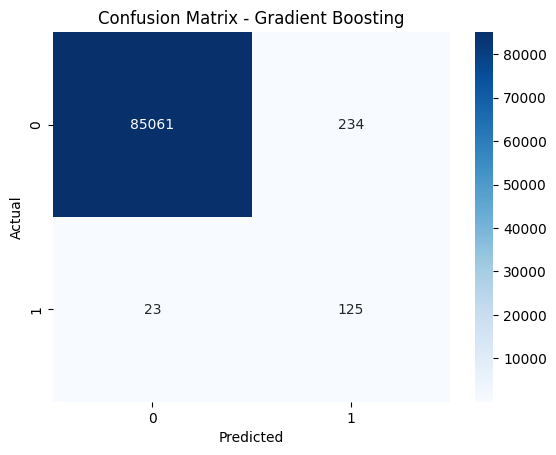


ROC-AUC Score: 0.9209255873494692


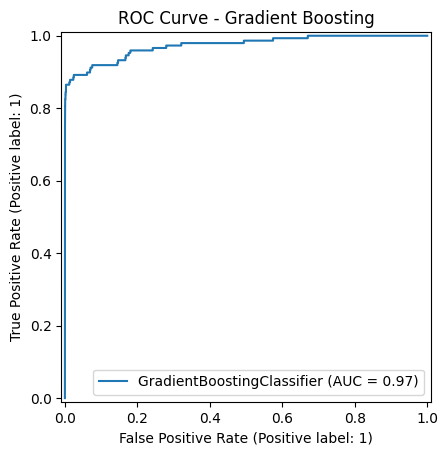

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
import matplotlib.pyplot as plt
import seaborn as sns

gb_model = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

gb_model.fit(X_train_balanced, y_train_balanced)

y_pred_gb = gb_model.predict(X_test)

print("Gradient Boosting Classification Report:\n")
print(classification_report(y_test, y_pred_gb, digits=4))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred_gb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

roc_auc = roc_auc_score(y_test, y_pred_gb)
print("\nROC-AUC Score:", roc_auc)


RocCurveDisplay.from_estimator(gb_model, X_test, y_test)
plt.title('ROC Curve - Gradient Boosting')
plt.show()


The Gradient Boosting model achieved strong results, with a **recall of 0.84**, **precision of 0.35**, and an overall **ROC-AUC score of 0.92**. While the precision is modest, the model successfully identifies the majority of fraudulent cases, which is typically the higher priority objective in fraud detection.

Compared to the Isolation Forest baseline (ROC-AUC ≈ 0.64), Gradient Boosting performs substantially better because it is a supervised algorithm that learns directly from labeled examples of fraud and non-fraud. It effectively captures the non-linear patterns in the PCA-transformed features, leading to a much clearer separation between the two classes.

In practice, this model strikes a good balance between detecting fraud and minimising false positives. Future steps could include threshold tuning or ensemble stacking to push precision higher without sacrificing recall.

# **6. Model Comparison and Summary**

,Model,Precision,Recall,F1-score,ROC-AUC
0,Isolation Forest,0.32,0.28,0.29,0.64
1,Gradient Boosting,0.35,0.84,0.49,0.92


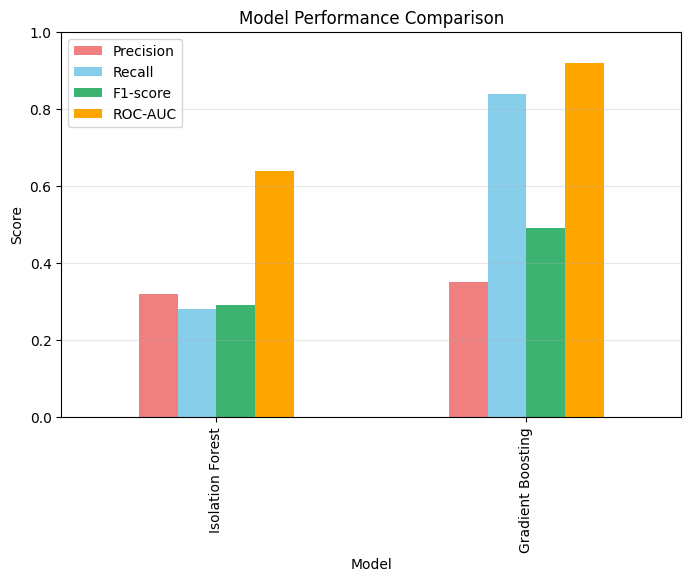

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

summary = pd.DataFrame({
    'Model': ['Isolation Forest', 'Gradient Boosting'],
    'Precision': [0.32, 0.35],
    'Recall': [0.28, 0.84],
    'F1-score': [0.29, 0.49],
    'ROC-AUC': [0.64, 0.92]
})

display(summary)


summary.set_index('Model')[['Precision', 'Recall', 'F1-score', 'ROC-AUC']].plot(
kind='bar', figsize=(8,5), color=['lightcoral', 'skyblue', 'mediumseagreen', 'orange']
)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.ylim(0,1)
plt.grid(axis='y', alpha=0.3)
plt.show()


While Isolation Forest is a powerful algorithm for anomaly detection and is widely used in fraud detection scenarios, its unsupervised nature limited performance here.

Without access to class labels, it relied only on statistical isolation, which struggled to capture the subtle feature interactions in this highly imbalanced dataset.

In contrast, the supervised Gradient Boosting model leveraged labeled data to learn precise class boundaries, achieving significantly higher recall and ROC-AUC.

This highlights the strength of supervised learning when reliable labels are available, while also showing how unsupervised methods can serve as valuable baselines for unlabeled or real-time data.

## 6.1 Feature Importance Visualisation

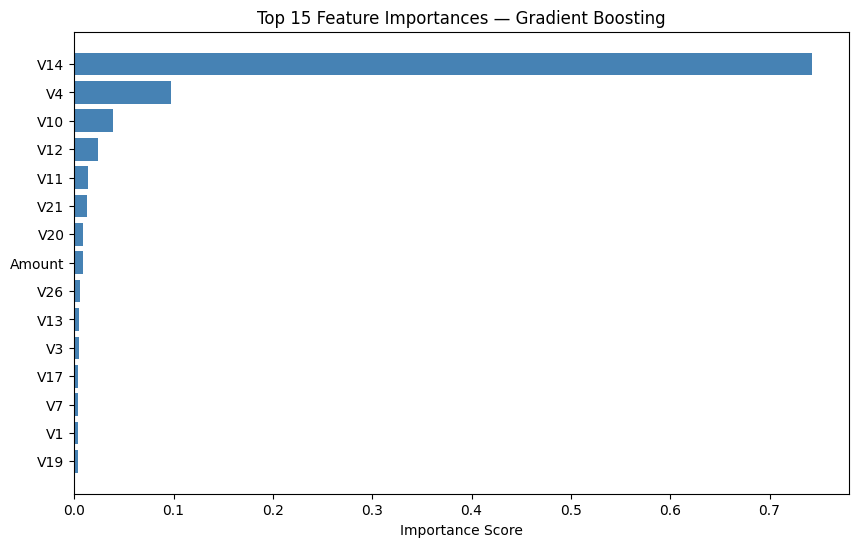

In [19]:
import numpy as np

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': gb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
plt.barh(feature_importance['Feature'][:15], feature_importance['Importance'][:15], color='steelblue')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances — Gradient Boosting')
plt.xlabel('Importance Score')
plt.show()


The Gradient Boosting model identified **V14, V4, and V10** as the most influential features in detecting fraud.  
These PCA-transformed components likely capture transaction patterns that strongly separate fraudulent from legitimate activity.  
While the exact meaning of each V-feature is unknown due to anonymisation, their consistent dominance suggests they encode unusual spending or behavioral patterns linked to fraud.  
The **Amount** variable also contributes, but with lower importance, indicating that transaction size alone is not a strong fraud indicator.

# **7. Conclusion**


Both unsupervised and supervised learning methods were applied to the same fraud dataset.  
Isolation Forest provided a fast, label-free anomaly baseline (ROC-AUC ≈ 0.64).  
Gradient Boosting, trained on oversampled labeled data, achieved ROC-AUC ≈ 0.92 with recall ≈ 0.84.  
These findings demonstrate how access to labeled data and class balancing dramatically improve detection of rare events.  
This project reflects practical skills in data preprocessing, imbalance handling, model evaluation, and interpretability.